In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Load datasets with string data type for 'tweet' column
depressed_df = pd.read_csv('/content/clean_depressed.csv', dtype={'tweet': str})
non_depressed_df = pd.read_csv('/content/clean_non_d.csv', dtype={'tweet': str})

# Add a 'label' column to each DataFrame
depressed_df['label'] = 1  # Set label to 1 for depressed tweets
non_depressed_df['label'] = 0  # Set label to 0 for non-depressed tweets

# Combine DataFrames using 'append'
df = pd.concat([depressed_df, non_depressed_df], ignore_index=True)


In [ ]:
# Split data into features (tweets) and labels
tweets = df['tweet'].astype(str).to_list()  # Convert to a list of strings
labels = df['label'].values

# Split data into train, validation, and test sets
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    tweets, labels, test_size=0.2, random_state=42)
train_tweets, validation_tweets, train_labels, validation_labels = train_test_split(
    train_tweets, train_labels, test_size=0.25, random_state=42)

# Tokenize the tweets
tokenizer = Tokenizer(num_words=10000)  # Adjust num_words as needed
tokenizer.fit_on_texts(train_tweets)

In [ ]:
# Convert tweets to sequences of indices
train_sequences = tokenizer.texts_to_sequences(train_tweets)
validation_sequences = tokenizer.texts_to_sequences(validation_tweets)
test_sequences = tokenizer.texts_to_sequences(test_tweets)

# Pad sequences to the same length
max_sequence_length = 100  # Adjust as needed
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length)
validation_padded = pad_sequences(validation_sequences, maxlen=max_sequence_length)
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length)

In [ ]:
from tensorflow.keras.regularizers import l2

# Create the optimized CNN-RNN model
model = Sequential()

# Embedding layer
model.add(Embedding(10000, 128))

# Conv1D layer with L2 regularization and Batch Normalization
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())  # Batch Normalization
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))  # Increased dropout after Conv1D

# LSTM layer with L2 regularization and increased dropout
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())  # Batch Normalization after LSTM

# Dense layer with L2 regularization and Dropout
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         1280000   
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          41024     
                                                                 
 batch_normalization_6 (Bat  (None, None, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, None, 64)          0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_3 (LSTM)               (None, 64)               

In [ ]:
# Early Stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model checkpoint to save the best model
checkpoint = ModelCheckpoint('optimized_cnn_rnn_model.h5', monitor='val_loss', save_best_only=True)

# Train the model with early stopping and checkpointing
history = model.fit(
    train_padded,
    train_labels,
    epochs=20,  # Increased epochs with early stopping
    validation_data=(validation_padded, validation_labels),
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/20
146/146 [==============================] - 11s 53ms/step - loss: 2.9036 - accuracy: 0.6374 - val_loss: 2.6239 - val_accuracy: 0.7143
Epoch 2/20
  3/146 [..............................] - ETA: 6s - loss: 2.4972 - accuracy: 0.6667

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


146/146 [==============================] - 7s 49ms/step - loss: 2.1679 - accuracy: 0.7807 - val_loss: 2.0588 - val_accuracy: 0.7651
Epoch 3/20
146/146 [==============================] - 7s 49ms/step - loss: 1.5995 - accuracy: 0.8631 - val_loss: 1.5586 - val_accuracy: 0.8102
Epoch 4/20
146/146 [==============================] - 7s 49ms/step - loss: 1.1824 - accuracy: 0.9077 - val_loss: 1.1851 - val_accuracy: 0.8263
Epoch 5/20
146/146 [==============================] - 7s 50ms/step - loss: 0.8676 - accuracy: 0.9386 - val_loss: 0.9628 - val_accuracy: 0.8539
Epoch 6/20
146/146 [==============================] - 7s 50ms/step - loss: 0.6552 - accuracy: 0.9515 - val_loss: 0.8222 - val_accuracy: 0.8546
Epoch 7/20
146/146 [==============================] - 7s 49ms/step - loss: 0.4997 - accuracy: 0.9629 - val_loss: 0.7351 - val_accuracy: 0.8571
Epoch 8/20
146/146 [==============================] - 7s 49ms/step - loss: 0.3844 - accuracy: 0.9704 - val_loss: 0.7809 - val_accuracy: 0.8314
Epoch 9/20

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_labels)
print('Test accuracy:', accuracy)

49/49 [==============================] - 0s 9ms/step - loss: 0.5700 - accuracy: 0.8539
Test accuracy: 0.853925347328186


In [ ]:
# Predict on the test set
predictions = model.predict(test_padded)

# Create a new DataFrame to store predictions
results_df = pd.DataFrame({'tweet': test_tweets, 'predicted_label': predictions.flatten()})

# Interpret predictions (0 = non-depressed, 1 = depressed)
results_df['predicted_label'] = np.where(results_df['predicted_label'] > 0.5, 1, 0)

# Print or save the results
print(results_df.to_string())  # Print the entire DataFrame
results_df.to_csv('prediction_results_CNN_RNN.csv', index=False)  # Save results to a CSV file

49/49 [==============================] - 1s 9ms/step
                                                                                                                                                                                                                                                                          tweet  predicted_label
0                                                                                                                                                                                                      it be okay just leave me alone i do not want to talk to anyone right now                1
1                                                                                                                                                                                                                                                      my shit come out tuesday                1
2              most people think it be stupid for apps to add stories i think th

In [ ]:
# Calculate evaluation metrics
predictions = model.predict(test_padded)
predicted_labels = np.where(predictions > 0.5, 1, 0)
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels)
confusion_mat = confusion_matrix(test_labels, predicted_labels)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print('Confusion Matrix:\n', confusion_mat)


49/49 [==============================] - 0s 8ms/step
Accuracy: 0.8539
Precision: 0.8189
Recall: 0.8228
F1-score: 0.8208
Confusion Matrix:
 [[807 115]
 [112 520]]


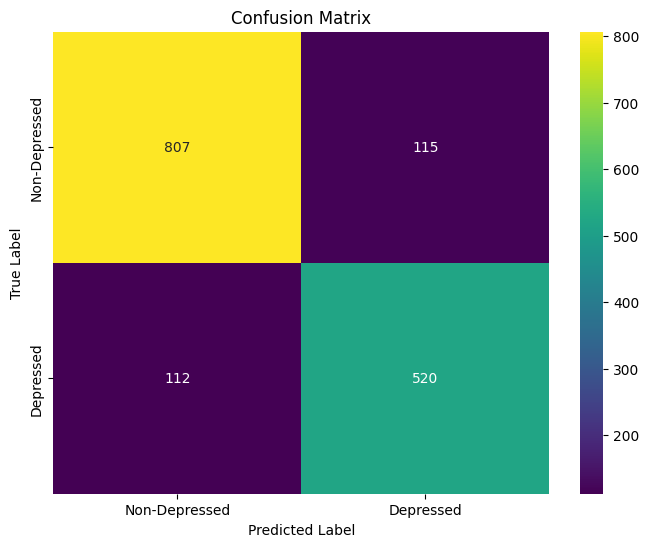

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="viridis",  # Use 'viridis' colormap
            xticklabels=['Non-Depressed', 'Depressed'],
            yticklabels=['Non-Depressed', 'Depressed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


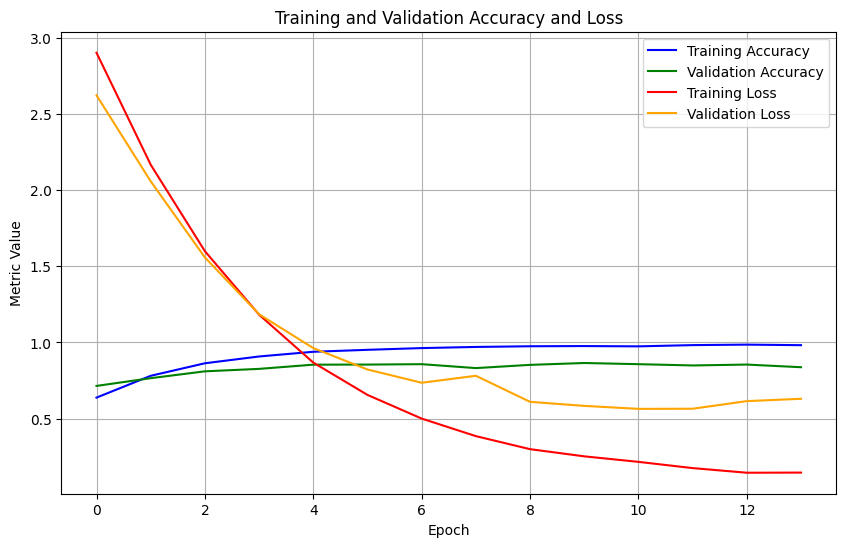

In [ ]:
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')

# Loss plot
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training and Validation Accuracy and Loss')
plt.legend()
plt.grid(True)  # Add grid lines
plt.show()
